# Homework 4 notes
## Wes Roberts

Import required libraries

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation
from IPython.display import HTML
import math
import itertools as itool

Define two lists of values that correspond to boundary conditions and initial configuration

In [2]:
class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)

In [3]:
StartConf.Confined

3

Define the particle object

In [5]:
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):                                # Pushes velocity ahead one timestep
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):                                 # pushes position ahead one timestep
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half

The move function pushes the particle ahead one timestep, under influence of the instantaneously defined force. Note that the presence of dt2half rather than $(0.5)*dt**2$ reduces computational burden.

Now we define the molecular dynamics system as an object. This will be populated with our 12 particles for the project. 

In [76]:
class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc):   # creates the object 
        self.N = N                           # System contains N specified particles
        self.lx = ly
        self.ly = lx                         # defined in a 2D box lx by ly
        self.dt = dt                         # a time step is defined
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5        # rather than computing 0.5 * dt**2 in the code
        self.bc = bc                         # boundary conditions are specified when object is created
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):               # initializes system with some defined configuration and velocities
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(self.N)*float(self.ly)/float(self.lx))
        ncols = int(math.sqrt(self.N)*float(self.lx)/float(self.ly))
        ax = float(lx) / float(ncols)
        ay = float(ly) / float(nrows)           
        i = 0

        if config == StartConf.Triangular:     # define the possible config inputs
            #Challenge
            nrows = int(math.sqrt(self.N))
            ncols = int(nrows)
            ax = float(lx)/float(ncols)
            ay = float(ly)/float(nrows)
            for row, col in itool.product(range(nrows),range(ncols)):
                self.particles[i].x = col*ax+ax/2.
                if row%2 == 1:
                    self.particles[i].x += ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Confined:
            ax /= 2.
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(self.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:                         # Assign each particle a random initial velocity
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;        # add up all the particle velocities in the system
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N           # divide by N. Now vcm is average velocity per particle, ie CoM
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;        # with this defined, subtract the CoM velocity from each particle velocity
                                # The system now has no overall velocity. The system itself will not translate. 
        self.forces()          
        
    def evolve(self):              # evolve() pushes the positions and velocities ahead one time step
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)        # operate with the boundary function
                                    # for example if RBC, particles that went outside "bounce" back in
        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):    # this one just returns the magnitude separation between a pair (see below)      
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):   # for a given pair, find the vector separation between them
        dx = other.x - p.x;
        dy = other.y - p.y;


        # nearest image convention
        if self.bc == BoundaryCondition.PBC:   # In PBC we need extra code to always take the shortest distance
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy       # also calculates the squared magnitude distance r12
        return (r12, dx, dy)          # returns all three values

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)   # grabs the distance and squared separation for the pair
        r2 = 1./r12
        r6 = r2 * r2 * r2                     # calculating in this way reduces computation time
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);                    # returns force in x and y on p
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):   # only taking j > i to avoid double-counting
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx     # Newton's 3rd
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:     # the boundary() function enforces selected boundary conditions
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx       # defines a "bounce" if a particle leaves the box
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx      # If it goes outside the box, appropriately shift it back inside
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
                
# this is where the assignment actually begins
            
    def kinetic_energy(self): # add up all the v**2
        ke = 0.
        for p in self.particles:
            vx2 = p.vx**2
            vy2 = p.vy**2
            vx2half = (0.5)*vx2
            vy2half = (0.5)*vy2
            ke += vx2half + vy2half
        return ke
    
    def temperature(self):     # define a function that calculates the system temperature
        temp = 0.
        for p in self.particles:
            vx2 = p.vx**2
            vy2 = p.vy**2
            v2 = vx2 + vy2
            temp += v2
        temp /= self.N
        temp /= 3.
        return temp
    
    def rescale(self, Tdes):    # define a function that rescales the velocities to produce a desired temperature
        factor = Tdes/self.temperature()
        rtfactor = math.sqrt(factor)
        for p in self.particles:
            p.vx *= rtfactor
            p.vy *= rtfactor
    
    def pot_energy(self): # add up all the particle-particle Lennard_Jones interactions
        pe = 0.
       
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):   # only taking j > i to avoid double-counting
                other = self.particles[j]
                v = self.potential(p, other)
                pe += v
               
        return pe
    
    def potential(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)   # grabs the distance and squared separation for the pair
        r2 = 1./r12
        r6 = r2 * r2 * r2                     # calculating in this way reduces computation time
        v = 4.*r6*(r6-1.)
        return v;                    # returns force in x and y on p
      
        
    def total_energy(self):
        return self.kinetic_energy()+self.pot_energy()
    
    
    def evolve100(self):  # Write a function that evolves the system forward 100 time steps
        for i in range(100):
            self.evolve()
    
      

Test kinetic_energy function

In [68]:
lx = 8
ly = 8
N = 2      # start with just 2 particles
dt = 0.001
v0 = 3

S = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
S.init(StartConf.Confined, v0)

In [69]:
S.kinetic_energy()

0.7227065921180008

In [70]:
S.evolve()

In [71]:
S.kinetic_energy()

0.7227782530355915

In [72]:
print(S.particles[0].vx)

vel1 = S.particles[0].vx

print(S.particles[0].vy)

vel2 = S.particles[0].vy

print(S.particles[1].vx)

vel3 = S.particles[1].vx

print(S.particles[1].vy)

vel4 = S.particles[1].vy

total = (0.5)*(vel1**2 + vel2**2 + vel3**2 + vel4**2)

temp1 = S.temperature()
av3 = (0.5)*(vel1**2 + vel2**2 + vel3**2 + vel4**2)/3.

print(f'The total kinetic energy is {total}')
print(f'The temperature is {temp1}, or directly calculated {av3}')

-0.4696610267423455
0.7086584318237646
0.4696610267423455
-0.7086584318237646
The total kinetic energy is 0.7227782530355915
The temperature is 0.24092608434519716, or directly calculated 0.24092608434519716


It does look like it's returning what I expect. Check whether it's conserved after system equilibrates.

In [73]:
S.rescale(1)

In [74]:
print(S.temperature())
print(S.kinetic_energy())
print(S.pot_energy())

1.0
3.0
-0.031815660923549365


In [101]:
lx = 8
ly = 8
N = 12
dt = 0.001
v0 = 1

Y = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Y.init(StartConf.Confined, v0)

print(Y.temperature())

0.1868266292502098


Obtain a plot showing convergence to the desired temperature. Begin with T = 1.

In [102]:
# Write a loop that does 10 iterations of 100 time steps.
# It needs to output the temperature at each step.

time_array = np.zeros(10)
temp_array = np.zeros(10)

for i in range(10):
    Y.evolve100()
    temp_array[i] = Y.temperature()
    time_array[i] = dt*i
    Y.rescale(1)
    

In [103]:
temp_array

array([19.06212919,  0.85757774,  1.23427348,  1.06648875,  0.88991517,
        1.07622597,  0.93596573,  0.97965383,  0.94127133,  1.05091549])

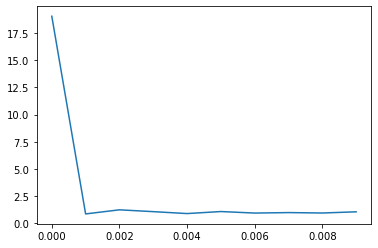

In [105]:
pyplot.plot(time_array, temp_array);